In [ ]:
# Install necessary libraries
!pip install scikit-learn pandas numpy matplotlib seaborn folium joblib -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')
# Set a random seed for reproducibility
np.random.seed(42)

In [ ]:
import numpy as np
import pandas as pd

# reproducible randomness (optional)
np.random.seed(42)

# ---------- charging station locations ----------
locations = {
    # Bengaluru Metropolitan Region
    'MG Road': [12.9741, 77.6052], 'Whitefield': [12.9698, 77.7499],
    'Electronic City': [12.8415, 77.6630], 'Koramangala': [12.9352, 77.6245],
    'Indiranagar': [12.9784, 77.6408], 'HSR Layout': [12.9104, 77.6418],
    'Yelahanka': [13.1007, 77.5963], 'Hebbal': [13.0358, 77.5970],
    'JP Nagar': [12.9053, 77.5858], 'Banashankari': [12.9256, 77.5467],
    'Rajajinagar': [12.9941, 77.5545], 'Marathahalli': [12.9592, 77.6974],
    'Sarjapur Road': [12.8963, 77.6910], 'Peenya': [13.0380, 77.5160],
    'Mysore Road (NICE Junction)': [12.9118, 77.4875], 'RT Nagar': [13.0190, 77.5973],
    'Domlur': [12.9583, 77.6486],

    # Mysuru Region
    'Mysore Palace': [12.3052, 76.6552], 'Kuvempunagar': [12.2936, 76.6374],
    'Hebbal Industrial Area (Mysuru)': [12.3562, 76.6014], 'Jayalakshmipuram': [12.3256, 76.6270],
    'Chamundi Hills': [12.2759, 76.6719], 'Nanjangud Road': [12.2150, 76.6700],
    'Vijayanagar 3rd Stage': [12.3225, 76.5925], 'Hunsur Road': [12.3340, 76.5980],

    # Mangalore Region
    'Forum Fiza Mall': [12.8703, 74.8423], 'City Centre Mall': [12.8723, 74.8426],
    'Pumpwell': [12.8549, 74.8552], 'Surathkal': [12.9803, 74.8025],
    'Kadri Hills': [12.8794, 74.8548], 'Bejai': [12.8820, 74.8488],
    'Panambur Port': [12.9369, 74.8056], 'Kottara Chowki': [12.8998, 74.8359],

    # Hubli Region
    'Vidya Nagar (Hubli)': [15.3649, 75.1241], 'Unkal Lake': [15.3645, 75.1062],
    'Gokul Road': [15.3550, 75.1202], 'Old Hubli': [15.3476, 75.1237],
    'Keshwapur': [15.3503, 75.1304],

    # Belgaum
    'Nehru Nagar (Belgaum)': [15.8668, 74.5044], 'Tilakwadi': [15.8592, 74.5058],
    'Khanapur Road': [15.8411, 74.5049], 'Udyambag': [15.8235, 74.5050],
    'RPD College Road': [15.8496, 74.5021],

    # Davangere
    'Davangere City Center': [14.4661, 75.9238], 'Mandipet': [14.4668, 75.9243],
    'Hadadi Road': [14.4570, 75.9352], 'SIT College Area': [14.4640, 75.9301],
    'Vinobanagar': [14.4801, 75.9125], 'Harihar Road': [14.5255, 75.8077],

    # Tumkur
    'Tumkur City': [13.3422, 77.1010], 'Kyathsandra': [13.3121, 77.1062],
    'SIT Tumkur': [13.3255, 77.1223],

    # Udupi
    'Manipal': [13.3524, 74.7898], 'Udupi City': [13.3409, 74.7421],
    'Malpe Beach': [13.3618, 74.7033],

    # Ballari
    'Ballari City': [15.1394, 76.9214], 'Cantonment': [15.1500, 76.9230],
    'Hospet Road': [15.2200, 76.4000],

    # Shimoga
    'Shimoga City': [13.9299, 75.5681], 'Gopala Gowda Extension': [13.9350, 75.5690],
    'BH Road': [13.9300, 75.5710]
}

# ---------- synthetic dataset ----------
n_samples = 2000
data = {
    'location_name': np.random.choice(list(locations.keys()), n_samples),
    'hour_of_day': np.random.randint(0, 24, n_samples),
    'day_of_week': np.random.randint(0, 7, n_samples),  # 0: Monday, 6: Sunday
    'temperature_celsius': np.random.uniform(20, 35, n_samples),
    'traffic_density': np.random.uniform(0.1, 1.0, n_samples),
    'grid_load_kw': np.random.uniform(50, 200, n_samples),
    'charger_type': np.random.choice(['AC_slow', 'DC_fast'], n_samples, p=[0.6, 0.4]),
    'weather_condition': np.random.choice(['Sunny', 'Rainy'], n_samples, p=[0.8, 0.2]),
    'is_event_day': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
}

df = pd.DataFrame(data)

# ---------- add lat/lon ----------
df['latitude'] = df['location_name'].map(lambda x: locations[x][0])
df['longitude'] = df['location_name'].map(lambda x: locations[x][1])

# ---------- engineer EV arrivals ----------
peak_hours = list(range(8, 11)) + list(range(18, 21))  # 8-10 and 18-20
df['is_peak'] = df['hour_of_day'].isin(peak_hours).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

df['ev_arrivals'] = (
    5
    + 5 * df['is_peak']           # peak hours
    + 3 * df['is_weekend']       # weekends
    + 2 * (df['weather_condition'] == 'Rainy').astype(int)
    + 10 * df['is_event_day']
    + np.random.poisson(2, n_samples)
)

# constrain arrivals between 1 and 30
df['ev_arrivals'] = df['ev_arrivals'].clip(lower=1, upper=30)

# ---------- simulate target: optimal_power_kw ----------
# base power: DC_fast ~25 kW, AC_slow ~8 kW
base_power = np.where(df['charger_type'] == 'DC_fast', 25.0, 8.0)

# calculate adjustment terms
grid_adjustment = 0.1 * (df['grid_load_kw'] - 100)      # positive if grid_load >100 => reduce more
traffic_adjustment = 10.0 * df['traffic_density']      # higher traffic => lower effective power
weekend_bonus = 5.0 * df['is_weekend']                 # increase power on weekends
peak_penalty = 3.0 * df['is_peak']                     # reduce power during evening peak

df['optimal_power_kw'] = (
    base_power
    - grid_adjustment
    - traffic_adjustment
    + weekend_bonus
    - peak_penalty
    + np.random.normal(0, 2, n_samples)   # noise
)

# clip to realistic bounds
df['optimal_power_kw'] = np.clip(df['optimal_power_kw'], 3.0, 50.0)

# rounding for readability
df = df.round(2)

print("✅ Advanced Synthetic Dataset Generated Successfully!")
print("\nDataset Snapshot:")
print(df.head())


✅ Advanced Synthetic Dataset Generated Successfully!

Dataset Snapshot:
                 location_name  hour_of_day  day_of_week  temperature_celsius  \
0        Nehru Nagar (Belgaum)           11            3                24.89   
1                   SIT Tumkur           15            3                24.49   
2                    Surathkal           23            0                23.49   
3  Mysore Road (NICE Junction)           11            6                21.95   
4             RPD College Road           14            1                23.85   

   traffic_density  grid_load_kw charger_type weather_condition  is_event_day  \
0             0.72         83.69      AC_slow             Rainy             0   
1             0.82        125.03      DC_fast             Sunny             0   
2             0.25        176.07      AC_slow             Sunny             0   
3             0.19        155.19      AC_slow             Rainy             0   
4             0.23        168.36    

In [ ]:
# Create a map of Bangalore centered on the average coordinates
map_center = [df['latitude'].mean(), df['longitude'].mean()]
bangalore_map = folium.Map(location=map_center, zoom_start=11)

# Function to apply correct color
def charger_color(charger_type):
    if str(charger_type).lower().startswith("dc"):   # DC_fast
        return "red"
    else:                                            # AC_slow
        return "green"

# Add markers for each station from the DataFrame (recommended)
for _, row in df.iterrows():
    color = charger_color(row['charger_type'])

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
            f"<strong>{row['location_name']}</strong><br>"
            f"Type: {row['charger_type']}<br>"
            f"Optimal Power: {row['optimal_power_kw']} kW<br>"
            f"Arrivals/hr: {row['ev_arrivals']}"
        ),
        icon=folium.Icon(color=color, icon="flash")
    ).add_to(bangalore_map)

# Display the map
print("🗺️ EV Charging Station Locations in Bangalore:")
bangalore_map


🗺️ EV Charging Station Locations in Bangalore:


Text(0.5, 1.0, 'Feature Correlation Heatmap')

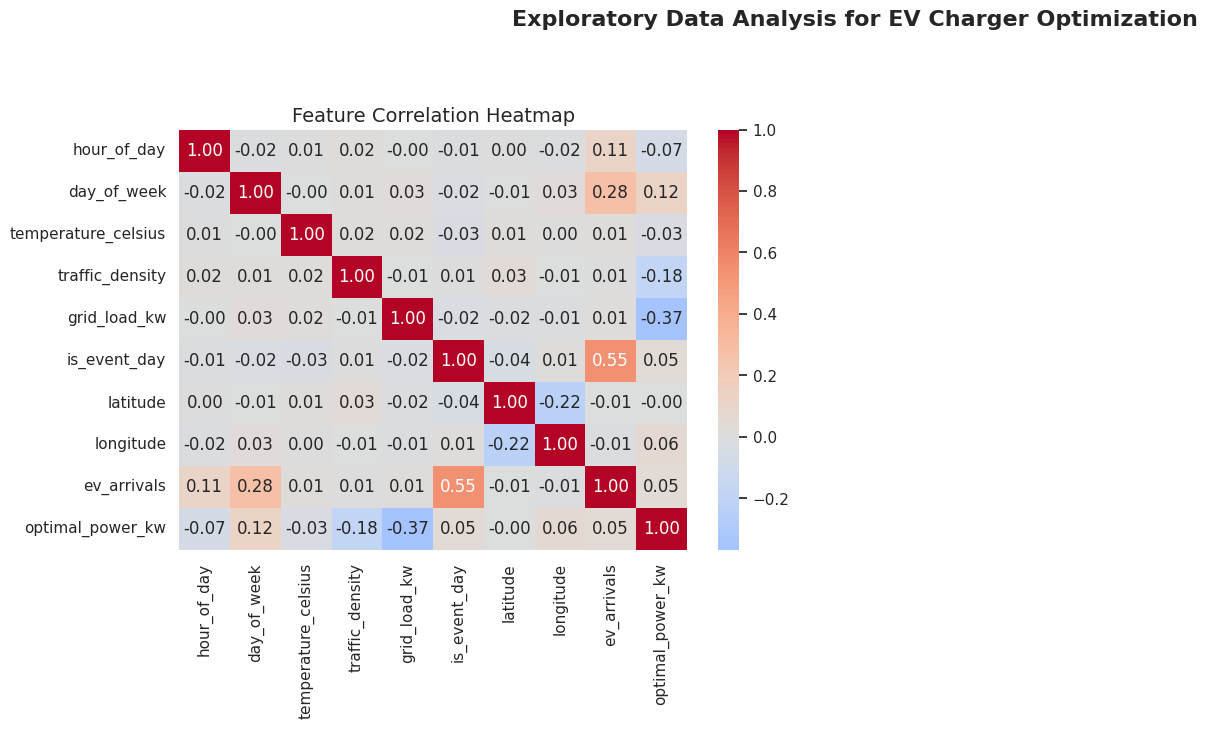

In [ ]:
# Visualize dataset patterns
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(18, 12))
plt.suptitle('Exploratory Data Analysis for EV Charger Optimization', fontsize=16, weight='bold')

# Correlation Heatmap
plt.subplot(2, 2, 1)
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Feature Correlation Heatmap', fontsize=14)

Text(0, 0.5, 'Optimal Power (kW)')

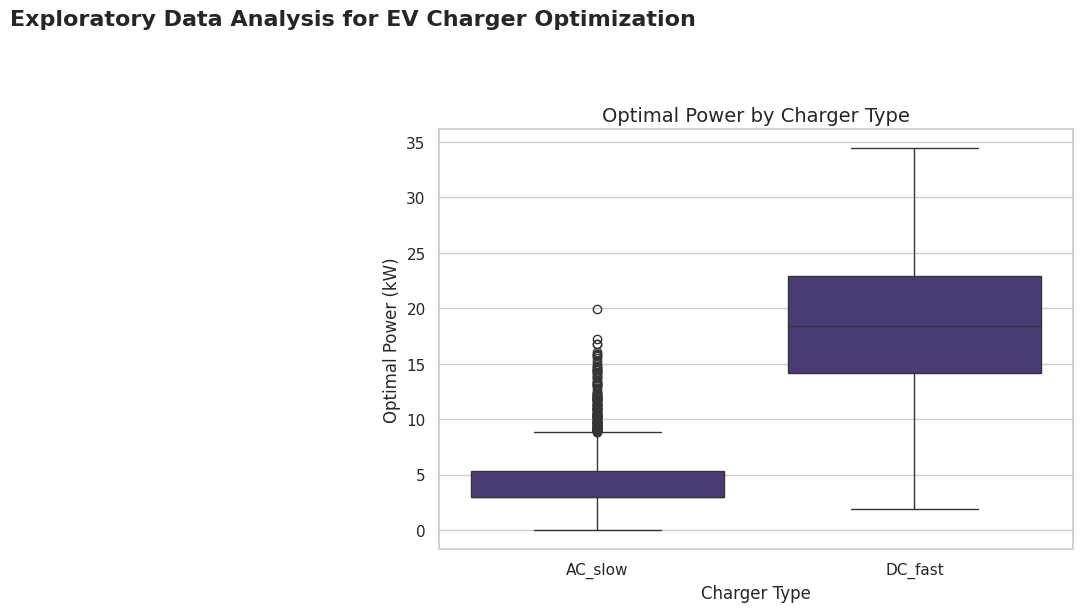

In [ ]:
# Visualize dataset patterns
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(18, 12))
plt.suptitle('Exploratory Data Analysis for EV Charger Optimization', fontsize=16, weight='bold')

# Optimal Power vs. Charger Type
plt.subplot(2, 2, 2)
sns.boxplot(x='charger_type', y='optimal_power_kw', data=df)
plt.title('Optimal Power by Charger Type', fontsize=14)
plt.xlabel('Charger Type', fontsize=12)
plt.ylabel('Optimal Power (kW)', fontsize=12)



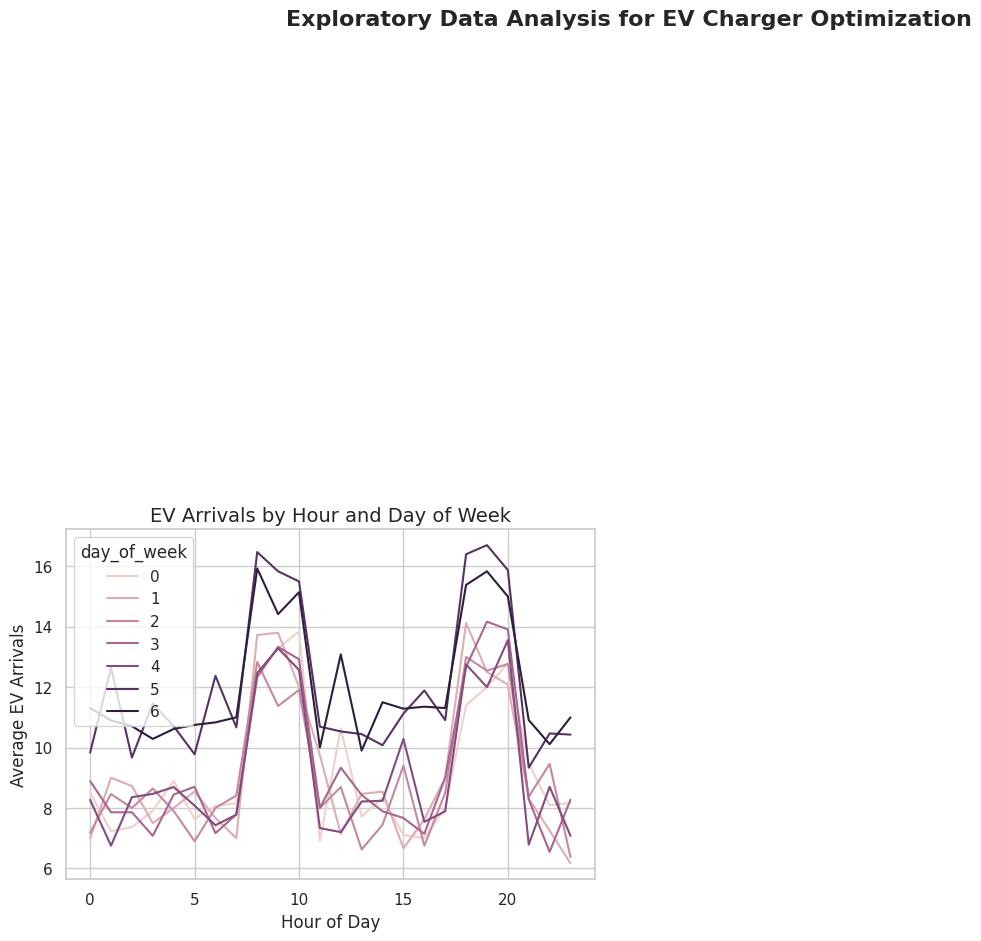

In [ ]:
# Visualize dataset patterns
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(15, 10))
plt.suptitle('Exploratory Data Analysis for EV Charger Optimization', fontsize=16, weight='bold')

# EV Arrivals vs. Hour of Day
plt.subplot(2, 2, 3)
sns.lineplot(x='hour_of_day', y='ev_arrivals', data=df, hue='day_of_week', ci=None)
plt.title('EV Arrivals by Hour and Day of Week', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average EV Arrivals', fontsize=12)
plt.grid(True)



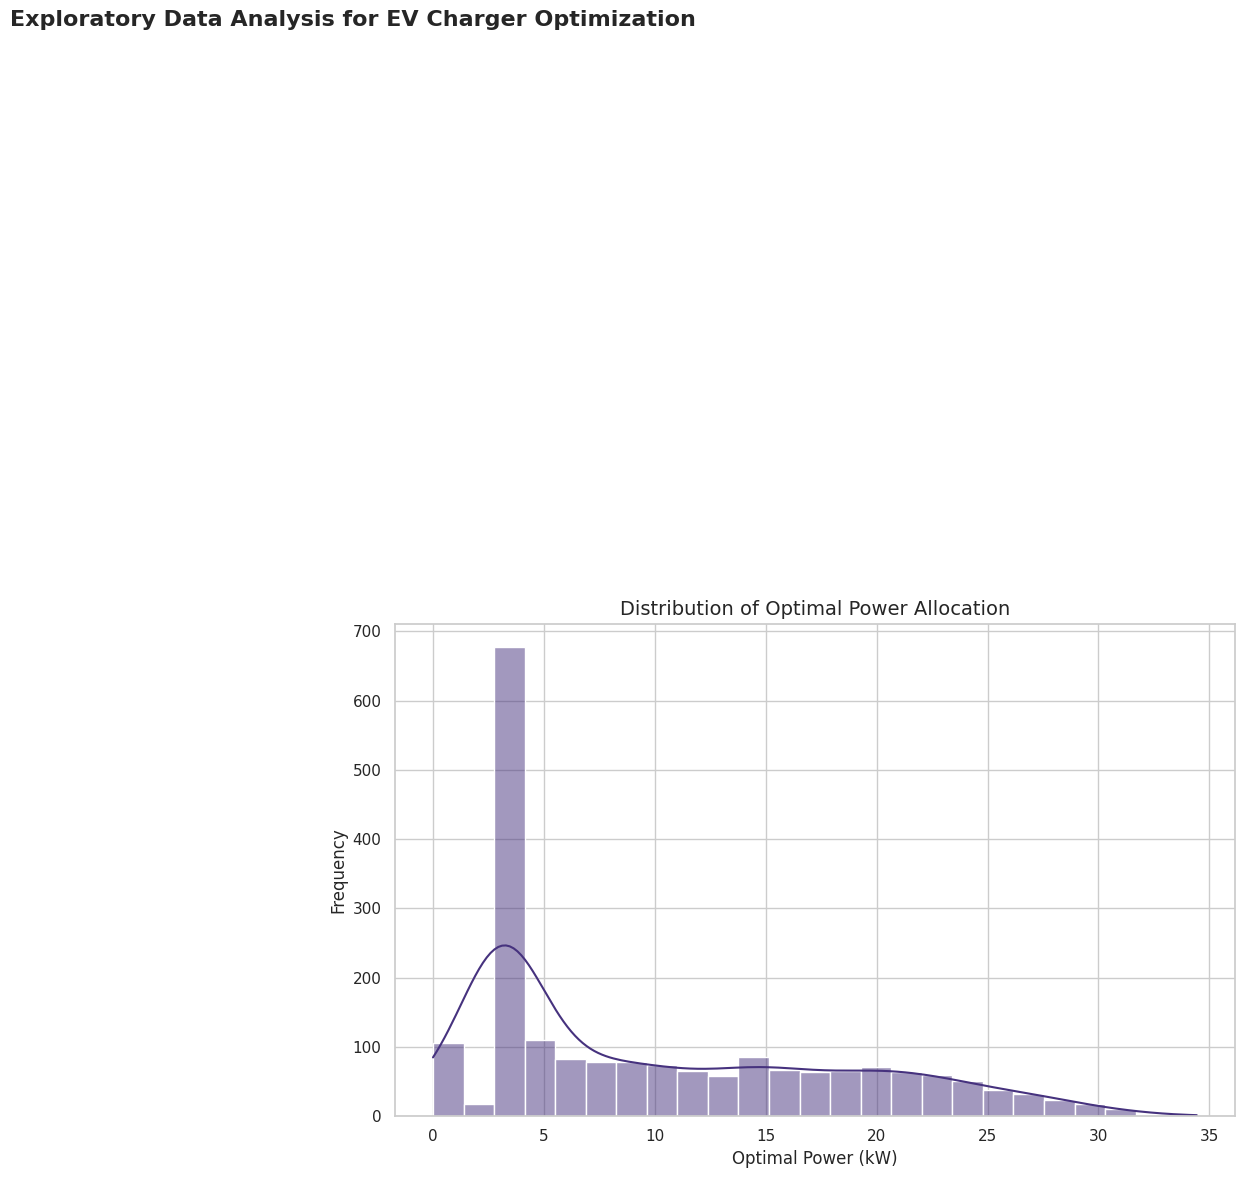

In [ ]:
# Visualize dataset patterns
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(18, 12))
plt.suptitle('Exploratory Data Analysis for EV Charger Optimization', fontsize=16, weight='bold')

# Distribution of Target Variable
plt.subplot(2, 2, 4)
sns.histplot(df['optimal_power_kw'], bins=25, kde=True)
plt.title('Distribution of Optimal Power Allocation', fontsize=14)
plt.xlabel('Optimal Power (kW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Define features (X) and target (y)
X = df.drop('optimal_power_kw', axis=1)
y = df['optimal_power_kw']

# Identify categorical and numerical features
categorical_features = ['location_name', 'charger_type', 'weather_condition']
numerical_features = ['hour_of_day', 'day_of_week', 'temperature_celsius', 'traffic_density', 'grid_load_kw', 'is_event_day', 'latitude', 'longitude', 'ev_arrivals']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 1600 samples
Test set size: 400 samples


In [ ]:
# Create the full pipeline with preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42, n_jobs=-1))
])

# Train the model
model_pipeline.fit(X_train, y_train)
print("🤖 Model trained successfully!")

# --- Model Evaluation ---
y_pred = model_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n**Model Performance on Test Data:**")
print(f"  - R² Score: {r2:.4f} (Model explains {r2:.1%} of the variance)")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kW (Average prediction error)")

🤖 Model trained successfully!

**Model Performance on Test Data:**
  - R² Score: 0.9526 (Model explains 95.3% of the variance)
  - Mean Absolute Error (MAE): 1.2539 kW (Average prediction error)


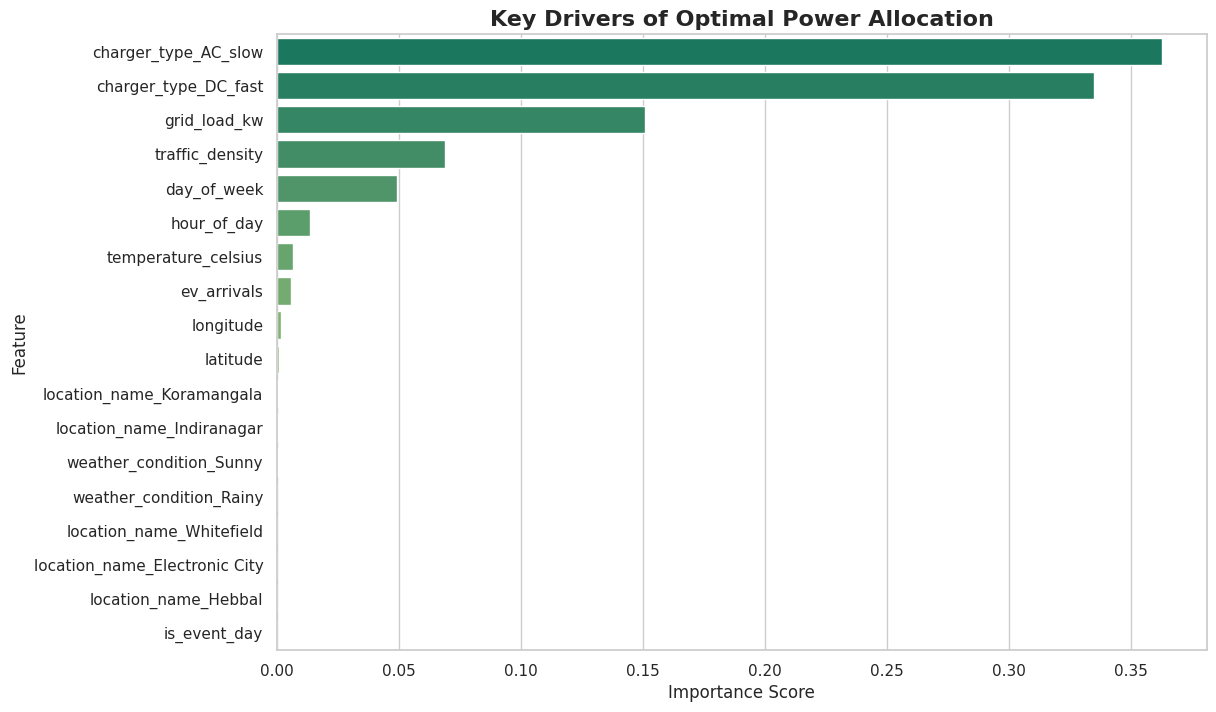

                 feature  importance
14  charger_type_AC_slow    0.362881
15  charger_type_DC_fast    0.335127
4           grid_load_kw    0.150842
3        traffic_density    0.069118
1            day_of_week    0.049223
0            hour_of_day    0.013761
2    temperature_celsius    0.006637
8            ev_arrivals    0.006076
7              longitude    0.001798
6               latitude    0.001182


In [ ]:
# Get feature names after one-hot encoding
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model_pipeline.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df, palette='summer')
plt.title('Key Drivers of Optimal Power Allocation', fontsize=16, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print(importance_df.head(10))

In [ ]:
# Simulate a real-time prediction scenario
new_scenario = pd.DataFrame({
    'location_name': ['Koramangala'],
    'hour_of_day': [19],
    'day_of_week': [1], # Tuesday
    'temperature_celsius': [25],
    'traffic_density': [0.9], # High traffic
    'grid_load_kw': [180], # High grid load
    'charger_type': ['DC_fast'],
    'weather_condition': ['Rainy'],
    'is_event_day': [0],
    'ev_arrivals': [10]
})

# Add lat/lon
new_scenario['latitude'] = new_scenario['location_name'].apply(lambda x: locations[x][0])
new_scenario['longitude'] = new_scenario['location_name'].apply(lambda x: locations[x][1])


# Predict the optimal power using the trained pipeline
optimal_power = model_pipeline.predict(new_scenario)[0]
total_power_demand = optimal_power * new_scenario['ev_arrivals'][0]
station_capacity = 150 # kW

print("--- 🏙️ Real-time Bangalore Scenario: Koramangala, 7 PM ---")
print(f"**Prediction:** Optimal power per EV = **{optimal_power:.2f} kW**")
print(f"**Total Demand:** For 10 EVs, predicted demand is **{total_power_demand:.2f} kW** (Station Capacity: {station_capacity} kW)")

# Simple rule-based optimization (throttling)
if total_power_demand > station_capacity:
    throttled_power = station_capacity / new_scenario['ev_arrivals'][0]
    print(f"⚠️ **Action:** Predicted demand exceeds capacity. Throttling power to **{throttled_power:.2f} kW** per EV to prevent overload.")
else:
    print("✅ **Action:** No throttling needed. Allocation is within station capacity.")

--- 🏙️ Real-time Bangalore Scenario: Koramangala, 7 PM ---
**Prediction:** Optimal power per EV = **6.22 kW**
**Total Demand:** For 10 EVs, predicted demand is **62.19 kW** (Station Capacity: 150 kW)
✅ **Action:** No throttling needed. Allocation is within station capacity.


In [ ]:
# Save the entire pipeline to a file
joblib.dump(model_pipeline, 'ev_charger_pipeline.pkl')

print("\n📦 Full model pipeline saved to 'ev_charger_pipeline.pkl' for deployment.")


📦 Full model pipeline saved to 'ev_charger_pipeline.pkl' for deployment.


In [ ]:
# Import libraries (if in a new cell, otherwise they are already imported from cell [1])
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np # We need numpy for the square root (np.sqrt)

# --- Model Evaluation ---
# Predict on the test set (as you did)
y_pred = model_pipeline.predict(X_test)

# Calculate existing metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# --- Code to Add ---
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print all performance metrics
print(f"\n**Model Performance on Test Data:**")
print(f"  - R² Score: {r2:.4f} (Model explains {r2:.1%} of the variance)")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kW (Average prediction error)")
print(f"  - Mean Squared Error (MSE): {mse:.4f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f} kW")


**Model Performance on Test Data:**
  - R² Score: 0.9526 (Model explains 95.3% of the variance)
  - Mean Absolute Error (MAE): 1.2539 kW (Average prediction error)
  - Mean Squared Error (MSE): 3.2502
  - Root Mean Squared Error (RMSE): 1.8028 kW
